# Lasso with reduced feature space
- WGCNA was used to cluster the transcription data
- account for multicolinearity

In [2]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler as zscore # zscore
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso #LRlasso
from joblib import dump, load #to save models in files
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import json
from datetime import datetime
import os

### Piplines from the python scripts 

In [2]:

from sklearn.model_selection import GridSearchCV
def gridcv(X, y, model, param_grid, naimpute=False, prepy=True, scorer = 'neg_mean_squared_error', cv_meth = LeaveOneOut(), cv_n_jobs = 1):
    """
    Perform Cross-Validation (defaukt: LOOCV) with hyperparameter tuning using GridSearchCV.
    
    Parameters:
    ----------
    X : pandas DataFrame or numpy array
        The feature matrix.
        
    y : pandas Series or numpy array
        The target variable.
        
    model : scikit-learn estimator
        The machine learning model to be used, should be an uninitialized model instance 
        (e.g., Lasso(), not Lasso(alpha=1.0)).
        
    param_grid : dict
        Dictionary containing the hyperparameters to be tuned and their possible values. 
        The keys should be prefixed with 'regressor__' to work with the pipeline.
        
    naimpute : bool, optional (default=False)
        Toggle imputation for missing values. 
        Currently not implemented; will print a message and return 0 if set to True.
        
    prepy : bool, optional (default=True)
        Toggle preprocessing target variable 'y' by setting any negative values to zero.
        
    scorer : str, callable, or None, optional (default='neg_mean_squared_error')
        A string or a scorer callable object / function with signature scorer(estimator, X, y). 
        For valid scoring strings, see the scikit-learn documentation.
        
    cv_meth : cross-validation generator, optional (default=LeaveOneOut())
        A cross-validation splitting strategy. 
        Possible inputs for cv are integers to specify the number of folds in a (Stratified)KFold, 
        CV splitter, cross-validation generator iterators, or an iterable.
        
    Returns:
    -------
    overall_metric : dict
        Dictionary containing the overall metrics and other details from the GridSearchCV.
        
    out_model : GridSearchCV object
        Fitted GridSearchCV object.
        
    best_params : dict
        Dictionary containing the best hyperparameters found by GridSearchCV.

    Call:
    ------
    from sklearn.model_selection import KFold

    # set up KFold cross-validator
    kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    param_grid = {
        'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
        'regressor__fit_intercept': [True, False]
    }
    print(param_grid)

    # Call the gridcv function with KFold as the cross-validation method
    lasso_fullkfold_scores, lasso_fullkfold_model, best_param = gridcv(
        X, 
        y,
        Lasso(max_iter=4000),
        param_grid,
        scorer='r2', 
        cv_meth=kfold_cv
    )
    dump(lasso_fullkfold_model, './models/lasso_fullkfold_model.pkl') # save the model as .pkl
    """

    # overall_metric = {'CV': cv_meth, 'scoring_metric': scorer} originally
    overall_metric = {'CV': str(cv_meth), 'scoring_metric': str(scorer)} # transformed to string because json dump scores later

    if prepy:
        y[y < 0] = 0
    
    if naimpute:
      print("not implemented")
      return 0


    pipeline = Pipeline([
        ('scaler', zscore()), 
        ('regressor', model)        # Regression model
    ])

    
    # declaring an Grid object
    # score : https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    out_model = GridSearchCV(pipeline, param_grid=param_grid, cv=cv_meth, scoring=scorer, n_jobs=cv_n_jobs).fit(X,y)
    # GridSearchCV need the regressor__ prefix for the pipiline object in the para_grid later when called

    best_pipeline = out_model.best_estimator_
    y_pred = best_pipeline.predict(X)

    overall_metric['correlation_true_pred'] = list(np.corrcoef(list(y), list(y_pred)))
    overall_metric['correlation_true_pred'][0] = list(overall_metric['correlation_true_pred'][0])
    overall_metric['correlation_true_pred'][1] = list(overall_metric['correlation_true_pred'][1])


    # LOOCV folds: split{i}_test_score (number of data points minus one) 
    overall_metric['fold_scores'] = [out_model.cv_results_[f'split{i}_test_score'][out_model.best_index_] for i in range(out_model.n_splits_)]
    best_params = out_model.best_params_


    # access the 'regressor' step from the best pipeline and then its coefficients
    coefficients = best_pipeline.named_steps['regressor'].coef_
    overall_metric['non_zero_coefficients'] = coefficients[coefficients != 0]
    overall_metric['non_zero_coefficients'] = overall_metric['non_zero_coefficients'].tolist()
    overall_metric['non_zero_features'] = list(X.columns[np.where(coefficients != 0)[0]])

    # printing section
    print("best parameter from gridsearch>>\n", out_model.best_params_)
    print(overall_metric['CV'])
    print(overall_metric['scoring_metric'])
    print("correlation Matrix>>\n", overall_metric['correlation_true_pred'])
    print("non_zero_features>>\n",overall_metric['non_zero_features'])
    print("scores for each fold>>\n",overall_metric['fold_scores'])

    return overall_metric, out_model, best_params


In [3]:

def nX_cross_validation(X, target, param_grid, scorer_estimate, output_prefix, random_states, output_path='./models/10xKfold/', n_splits=3, cv_n_jobs=1):
    if os.path.exists(output_path):
        print(f"The path {output_path} exists.")
    else:
        print(f"The path {output_path} does not exist.")
        raise FileNotFoundError(f"The path {output_path} does not exist.")
    best_fold_mean = float('-inf')
    best_model = []
    #cv_results = {'random_state': [], 'scores': {}, 'mean_scores': [], 'common_features': {}, 'model': {}}
    cv_results = {'random_state': [], 'scores': {}, 'mean_scores': [], 'selected_features': {}, 'best_param': []}
    for ran_state in random_states:
        print(ran_state)
        kfold_cv = KFold(n_splits=n_splits, shuffle=True, random_state=ran_state)
        scores, model, best_param = gridcv(
            X, 
            target,
            Lasso(max_iter=8000),
            param_grid,
            prepy=False,
            scorer=scorer_estimate, 
            cv_meth=kfold_cv,
            cv_n_jobs=cv_n_jobs
        )
        cv_results['random_state'].append(ran_state)
        cv_results['scores'][ran_state] = scores
        cv_results['mean_scores'].append(np.mean(scores['fold_scores']))
        if best_fold_mean == -100:
            best_fold_mean = np.mean(scores['fold_scores'])
            cv_results['best_param'] = best_param, ran_state, np.mean(scores['fold_scores'])
        elif best_fold_mean < np.mean(scores['fold_scores']):
            best_fold_mean = np.mean(scores['fold_scores'])
            cv_results['best_param'] = best_param, ran_state, np.mean(scores['fold_scores'])


        # cv_results['model'][ran_state] = model

    # Determine common features...
    #cv_results['common_features'] = set(cv_results['scores'][42]['non_zero_features'])
    #for r in cv_results['random_state'][1:]:
    #    current_features = set(cv_results['scores'][r]['non_zero_features'])
    #    cv_results['common_features'] = cv_results['common_features'].intersection(current_features)
    #cv_results['common_features'] = list(cv_results['common_features'])
    print(f"best estimator>>\n found in split: {cv_results['best_param'][1]}\n param_grid: {cv_results['best_param'][0]}\n mean fold score {cv_results['best_param'][2]}")    
    best_model = Lasso(alpha=cv_results['best_param'][0]['regressor__alpha'], fit_intercept=cv_results['best_param'][0]['regressor__fit_intercept']).fit(X, target)
    cv_results['selected_features'] = list(X.columns[np.where(best_model.coef_ != 0)[0]])
    #save to json
    with open(f"{output_path}{output_prefix}_nXcv.json", 'w') as file:
       json.dump(cv_results, file)
    file.close()

    return cv_results


In [4]:
def to_valid_variable_name(name):
    # Replace special characters with underscores
    name = re.sub(r'\W|^(?=\d)', '_', name)
    # Reduce multiple consecutive underscores to one
    name = re.sub(r'_{2,}', '_', name)
    # Truncate length if necessary
    max_length = 30
    if len(name) > max_length:
        name = name[:max_length]
    # Ensure it doesn't start with a number
    if name[0].isdigit():
        name = "_" + name
    return name


In [5]:
#gcms_mut = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/gcms_mut.csv", sep=",")
#lcms_mut = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/lcms_mut.csv", sep=",")
gcms_mut = pd.read_csv("/work/yhesse/PW_rawdata/tr_gc_mutual/gcms_mut.csv", sep=",")
lcms_mut = pd.read_csv("/work/yhesse/PW_rawdata/tr_gc_mutual/lcms_mut.csv", sep=",")



In [6]:
X = pd.read_csv("/work/yhesse/PW_rawdata/tr_gc_mutual/tr_wgcna_MEs.csv", sep=",", index_col=0)
X.head()


,MEdarkred,MEsalmon,MEsienna,MEdarkgrey,MEchocolate,MElightsalmon,MErosybrown,MEred,MEsaddlebrown,MEblack,MEmaroon,MEtomato,MEperu,MElinen,MEorangered,MEmistyrose,MEdimgrey,MEseashell
ref,,,,,,,,,,,,,,,,,,
Xe_De_R2_T00,-0.070542,-0.076521,-0.036572,0.273065,-0.063839,0.104769,-0.069150,-0.026775,0.142589,-0.095037,-0.025330,0.155800,0.087210,0.335986,0.072189,-0.121119,-0.098802,-0.143420
Xe_De_R2_T03,0.660550,0.047808,-0.036807,0.017875,0.000776,0.033626,0.122773,0.050396,0.269496,0.099744,-0.033325,0.074530,-0.039596,-0.040912,-0.194549,-0.011116,-0.168250,-0.127068
Xe_De_R2_T06,0.135545,0.240469,0.044559,0.038486,0.337999,0.101275,0.353547,0.583660,0.233476,0.204601,0.083258,-0.067397,-0.371903,-0.414662,-0.220544,-0.043053,-0.138183,-0.177591
Xe_De_R2_T09,-0.010512,0.006573,-0.030147,-0.068341,0.128373,0.098445,0.256827,0.139581,0.075497,0.019816,0.178133,0.111921,-0.104833,-0.068798,0.036791,-0.034521,-0.146483,-0.129996
Xe_De_R2_T12,0.029663,0.192380,-0.222354,-0.147784,-0.191662,-0.138411,-0.049868,-0.013878,-0.033662,-0.055919,0.091908,0.196573,-0.093520,-0.077363,0.015746,0.421891,-0.109746,0.176336


In [7]:
gcms_target_dict = {}
for target in gcms_mut['metabolite']:
    o = to_valid_variable_name(target)
    #print(f"{o} == \t {target}")
    gcms_target_dict[o] = str(target)


lcms_target_dict = {}
for target in lcms_mut['metabolite']:
    o = to_valid_variable_name(target)
    #print(f"{o} == \t {target}")
    lcms_target_dict[o] = str(target)
        

In [47]:
np.logspace(-4, 1, 20)
##old grid
#param_grid = {
#    'regressor__alpha': np.array(np.arange(0.0125, 0.0625, 0.0025)),
#    'regressor__fit_intercept': [True, False]
#}

array([1.00000000e-04, 1.83298071e-04, 3.35981829e-04, 6.15848211e-04,
       1.12883789e-03, 2.06913808e-03, 3.79269019e-03, 6.95192796e-03,
       1.27427499e-02, 2.33572147e-02, 4.28133240e-02, 7.84759970e-02,
       1.43844989e-01, 2.63665090e-01, 4.83293024e-01, 8.85866790e-01,
       1.62377674e+00, 2.97635144e+00, 5.45559478e+00, 1.00000000e+01])

In [7]:
param_grid = {
    'regressor__alpha': np.logspace(-4, 1, 20),
    'regressor__fit_intercept': [True]
}
cpus = 12
tenX = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
print(f"parameter grid >>\n {param_grid}")




parameter grid >>
 {'regressor__alpha': array([1.00000000e-04, 1.83298071e-04, 3.35981829e-04, 6.15848211e-04,
       1.12883789e-03, 2.06913808e-03, 3.79269019e-03, 6.95192796e-03,
       1.27427499e-02, 2.33572147e-02, 4.28133240e-02, 7.84759970e-02,
       1.43844989e-01, 2.63665090e-01, 4.83293024e-01, 8.85866790e-01,
       1.62377674e+00, 2.97635144e+00, 5.45559478e+00, 1.00000000e+01]), 'regressor__fit_intercept': [True]}


In [ ]:
out = '/work/yhesse/jobs/xele_ml/newfeat_lasso/gcms/'

print(f"parameter grid >>\n {param_grid}")

for i, (gcms_target, orig_str) in enumerate(gcms_target_dict.items()):
    now = datetime.now()
    print(f"\n>> START {gcms_target} {now.isoformat()} <<")
    tmp_10xKfold = nX_cross_validation(X.iloc[:,:], gcms_mut.iloc[i,1:], param_grid, 'r2', str(gcms_target), random_states=tenX, output_path=out, cv_n_jobs=cpus)
    print(f"\n>> DONE <<\n\n")

with open(f"{out}gcms_dict_nXcv.json", 'w') as file:
    json.dump(gcms_target_dict, file)


In [ ]:

out = '/work/yhesse/jobs/xele_ml/newfeat_lasso/lcms/'

for i, (lcms_target, orig_str) in enumerate(lcms_target_dict.items()):
    now = datetime.now()
    print(f"\n>> START {lcms_target} {now.isoformat()} <<")
    print(f"{lcms_mut.iloc[i,0]}\t{lcms_target}")
    tmp_10xKfold = nX_cross_validation(X.iloc[:,:], lcms_mut.iloc[i,1:], param_grid, 'r2', str(lcms_target), random_states=tenX, output_path=out, cv_n_jobs=cpus)
    print(f"\n>> DONE <<\n\n")


with open(f"{out}lcms_dict_nXcv.json", 'w') as file:
    json.dump(lcms_target_dict, file)


# Reading score data

In [34]:

path_gc = "/home/t44p/PW_rawdata/results/newfeat_lasso/gcms/"
path_lc ="/home/t44p/PW_rawdata/results/newfeat_lasso/lcms/"

#path_gc = "/home/t44p/PW_rawdata/results/newfeat_lasso/gcms/"
#path_lc ="/home/t44p/PW_rawdata/results/newfeat_lasso/lcms/"
lasso_results = {}


# Iterate over each file in the directory
for p in [path_gc, path_lc]:

    for file in os.listdir(p):
        if file.endswith(".json") and not(file.startswith('gcms_dict_nXcv') or file.startswith('lcms_dict_nXcv')):
            file_path = os.path.join(p, file)
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            
            # Extract mean scores and fold scores
            print(file)
            
                
            all_means = data['mean_scores']
            all_fold_scores = []
            for item, values in data['scores'].items():
                all_fold_scores.extend(values['fold_scores'])

            # Use file name without extension as the key
            file_name = os.path.splitext(file)[0]
            lasso_results[file_name] = {
                'all_mean_scores': all_means,
                'mean_10x': np.mean(all_means),
                'all_fold_scores': all_fold_scores,
                'best_param': data['best_param']
            }

len(lasso_results.keys())

Cellobiose_361_204_rt14_40_nXcv.json
tyrosine_218_280_rt10_78_nXcv.json
threonic_acid_292_220_rt7_49_nXcv.json
isoleucin_158_233_rt_5_21_nXcv.json
asparagine_116_188_rt9_00_nXcv.json
adenine_264_279_rt11_12_nXcv.json
glycerol_117_205_rt4_75_nXcv.json
raffinose_437_451_rt16_91_nXcv.json
adenosine_5_monophosphate_169__nXcv.json
ornithine_142_174_rt9_34_nXcv.json
glucose_160_rt9_81_nXcv.json
inositol_myo_305_265_rt10_71_nXcv.json
phosphoric_acid_314_299_rt_5_4_nXcv.json
sucrose_437_361_rt13_77_nXcv.json
hexose_307_217_rt9_58_nXcv.json
alanine_3_cyano_141_100_rt6_78_nXcv.json
threonine_219_291_rt6_01_nXcv.json
tryptophan_202_291_rt12_94_nXcv.json
citric_acid_273_375_rt9_72_nXcv.json
alanine_116_218_rt3_38_nXcv.json
glucose_1_phosphate_217_rt9_16_nXcv.json
leucine_158_232_rt4_97_nXcv.json
trehalose_alpha_alpha_191_169__nXcv.json
quinic_acid_255_345_rt9_45_nXcv.json
Oxalic_acid_219_147_3_94_nXcv.json
valine_144_218_rt4_42_nXcv.json
dopamine_174_426_rt11_11_nXcv.json
galactinol_204_191_rt15_3

243

### Hyperparameters

In [35]:
param_grid = {
    'regressor__alpha': np.logspace(-4, 1, 20),
    'regressor__fit_intercept': [True]
}
print(f"parameter grid >>\n {param_grid}")

lasso_results['Cellobiose_361_204_rt14_40_nXcv']
for key in lasso_results.keys():
    print(f"{lasso_results[key]['mean_10x']}\t{lasso_results[key]['best_param']}")

parameter grid >>
 {'regressor__alpha': array([1.00000000e-04, 1.83298071e-04, 3.35981829e-04, 6.15848211e-04,
       1.12883789e-03, 2.06913808e-03, 3.79269019e-03, 6.95192796e-03,
       1.27427499e-02, 2.33572147e-02, 4.28133240e-02, 7.84759970e-02,
       1.43844989e-01, 2.63665090e-01, 4.83293024e-01, 8.85866790e-01,
       1.62377674e+00, 2.97635144e+00, 5.45559478e+00, 1.00000000e+01]), 'regressor__fit_intercept': [True]}
0.4417492776266172	[{'regressor__alpha': 0.0069519279617756054, 'regressor__fit_intercept': True}, 45, 0.5451325565915431]
-0.06705005593906192	[{'regressor__alpha': 0.04281332398719392, 'regressor__fit_intercept': True}, 50, 0.10405555912750337]
0.7347435920182719	[{'regressor__alpha': 0.00379269019073225, 'regressor__fit_intercept': True}, 49, 0.816702458395004]
0.050321881827415794	[{'regressor__alpha': 0.023357214690901212, 'regressor__fit_intercept': True}, 49, 0.27162376403597915]
-0.06615898244874707	[{'regressor__alpha': 0.012742749857031334, 'regressor

### variances

In [36]:
variances = [np.var(target_data['all_fold_scores']) for target_data in lasso_results.values()]
c = 0
print(max(variances))
print(f"target\t score variance across 10 runs\t min score\tmax score")
for item, target_data in lasso_results.items():
    np.var(target_data['all_fold_scores'])
    if np.var(target_data['all_fold_scores']) > 2:
        print(f"{item}\t{np.var(target_data['all_fold_scores'])}\t{min(target_data['all_fold_scores'])}\t{max(target_data['all_fold_scores'])} ")# {max(target_data['all_fold_scores'])}
        c += 1
print(c)

63.53500352148913
target	 score variance across 10 runs	 min score	max score
_D_Glycero_alpha_D_Manno_Hepto_nXcv	6.073305620124308	-14.47897098191607	0.2015549263938754 
Triterpene_8_14_nXcv	63.53500352148913	-46.66783965912978	-0.00010702172278453936 
2


#### plot all variances

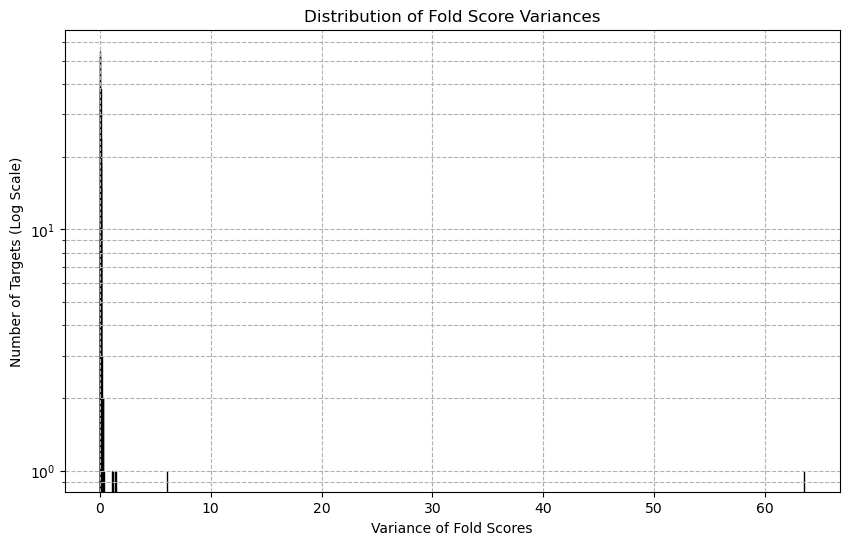

In [37]:
# Calculate the variances of fold scores for each target
variances = [np.var(target_data['all_fold_scores']) for target_data in lasso_results.values()]

# Since we have variances that are very high, we will use a logarithmic scale on the y-axis.
# We also use a wider range of bins to capture the high variance values.

# Find the maximum variance to define the end of the bin range
max_variance = max(variances)

# Define the number of bins or use 'auto' for automatic binning
num_bins = 'auto'  # You can also specify an integer for a fixed number of bins

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(variances, bins=num_bins, edgecolor='black', log=True)  # Note the log=True parameter
plt.title('Distribution of Fold Score Variances')
plt.xlabel('Variance of Fold Scores')
plt.ylabel('Number of Targets (Log Scale)')
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks
plt.show()

### exlude the variance > 2 by binning

bins [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ], average bin size 0.05


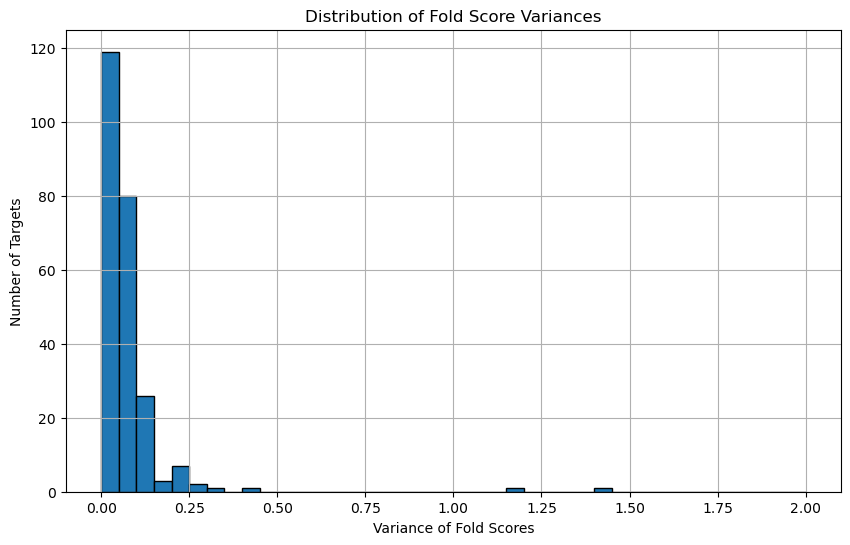

In [38]:


# Plotting the histogram
plt.figure(figsize=(10, 6))
bins=np.arange(0, 2.05, 0.05)
bin_sizes = np.diff(bins)
print(f"bins {bins}, average bin size {np.mean(bin_sizes)}")
plt.hist(variances, bins=bins, edgecolor='black')
plt.title('Distribution of Fold Score Variances')
plt.xlabel('Variance of Fold Scores')
plt.ylabel('Number of Targets')
plt.grid(True)
plt.show()


Bin sizes: [0.13507786 0.13507786 0.13507786 0.13507786 0.13507786 0.13507786
 0.13507786 0.13507786 0.13507786 0.13507786 0.13507786 0.13507786
 0.13507786 0.13507786 0.13507786 0.13507786 0.13507786 0.13507786]
Average bin size: 0.135077858505087


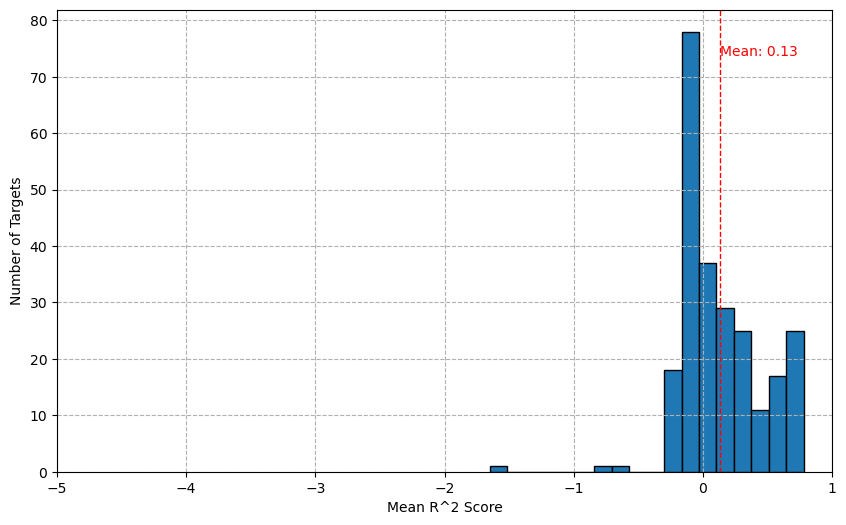

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

all_mean_scores = [lasso_results[target_data]['mean_10x'] for target_data in lasso_results.keys()]
mean_score = np.mean(all_mean_scores)

bin_edges = np.histogram_bin_edges(all_mean_scores, bins='auto')
bin_sizes = np.diff(bin_edges)  # Calculate the bin sizes
print("Bin sizes:", bin_sizes)
average_bin_size = np.mean(bin_sizes)
print("Average bin size:", average_bin_size)
plt.hist(all_mean_scores, bins=bin_edges, edgecolor='black')

# Set the x-axis label
plt.xlabel('Mean R^2 Score')

# Set the y-axis label
plt.ylabel('Number of Targets')


# Set x-axis ticks
xticks_major = np.arange(-5, max(all_mean_scores) + 1, 1)
plt.xticks(xticks_major)

# Draw a vertical line for the mean score
plt.axvline(mean_score, color='red', linestyle='dashed', linewidth=1)

# Annotate the mean score
plt.text(mean_score, plt.gca().get_ylim()[1]*0.9, f'Mean: {mean_score:.2f}', color = 'red')

# Add grid lines
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks

# Display the plot
plt.show()


### exclude target with mean R² < -1

In [40]:
c = 0
# exclude models that are worse than -1
all_mean_scores = [lasso_results[target_data]['mean_10x'] for target_data in lasso_results if lasso_results[target_data]['mean_10x'] > -1]
for target_data in lasso_results:
    if lasso_results[target_data]['mean_10x'] <= -1:
        print(f"{target_data} with mean score\t{round(lasso_results[target_data]['mean_10x'], 3)}")
        c += 1
print(c)


Triterpene_8_14_nXcv with mean score	-1.651
1


Bin sizes: [0.1376919 0.1376919 0.1376919 0.1376919 0.1376919 0.1376919 0.1376919
 0.1376919 0.1376919 0.1376919 0.1376919]
Average bin size: 0.13769190378476698


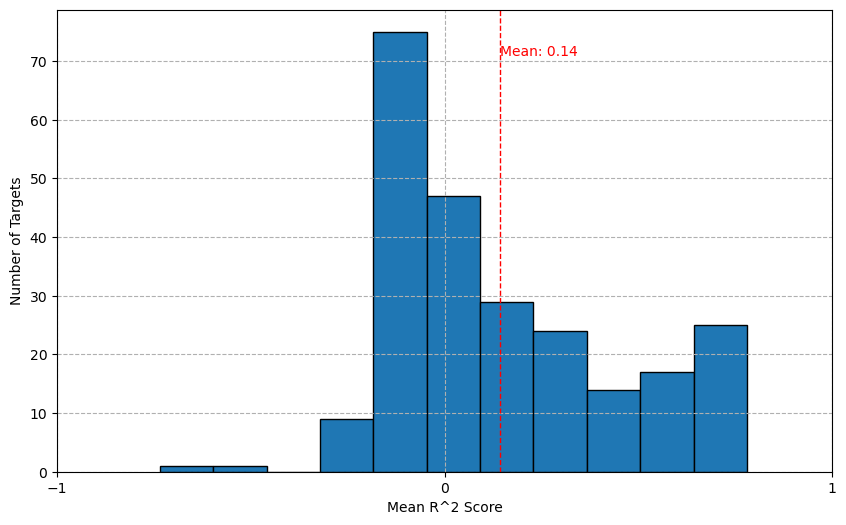

In [43]:
mean_score = np.mean(all_mean_scores)
plt.figure(figsize=(10, 6))
bin_edges = np.histogram_bin_edges(all_mean_scores, bins='auto')
bin_sizes = np.diff(bin_edges)  # Calculate the bin sizes
print("Bin sizes:", bin_sizes)
average_bin_size = np.mean(bin_sizes)
print("Average bin size:", average_bin_size)
plt.hist(all_mean_scores, bins=bin_edges, edgecolor='black')

# Set the x-axis label
plt.xlabel('Mean R^2 Score')

# Set the y-axis label
plt.ylabel('Number of Targets')

# Set x-axis ticks
xticks_major = np.arange(-1, max(all_mean_scores) + 1, 1)
plt.xticks(xticks_major)

# Draw a vertical line for the mean score
plt.axvline(mean_score, color='red', linestyle='dashed', linewidth=1)

# Annotate the mean score
plt.text(mean_score, plt.gca().get_ylim()[1]*0.9, f'Mean: {mean_score:.2f}', color = 'red')

# Add grid lines
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks

# Display the plot
plt.show()


In [42]:
print(f"target\t score variance across 10 runs\t mean Score 10x\t predictive power")
for item, target_data in lasso_results.items():
    score_variance = np.var(target_data['all_fold_scores'])
    mean_score = target_data['mean_10x']

    # Good models
    if score_variance < 0.25 and mean_score > 0.5:
        print(f"{item}\t{score_variance}\t{mean_score}\t good")

    # Mediocre models
    elif 0.25 <= score_variance < 0.5 and 0.25 <= mean_score < 0.5:
        print(f"{item}\t{score_variance}\t{mean_score}\t mediocre")

    # poor models
    elif score_variance >= 0.5 or mean_score < 0.25:
        print(f"{item}\t{score_variance}\t{mean_score}\t poor")
    else:
        print(f"{item}\t{score_variance}\t{mean_score}\t stable_underperforming")



target	 score variance across 10 runs	 mean Score 10x	 predictive power
Cellobiose_361_204_rt14_40_nXcv	0.08659773336471988	0.4417492776266172	 stable_underperforming
tyrosine_218_280_rt10_78_nXcv	0.10748464669637939	-0.06705005593906192	 poor
threonic_acid_292_220_rt7_49_nXcv	0.016864243691683222	0.7347435920182719	 good
isoleucin_158_233_rt_5_21_nXcv	0.04396773731982333	0.050321881827415794	 poor
asparagine_116_188_rt9_00_nXcv	0.022228904138938247	-0.06615898244874707	 poor
adenine_264_279_rt11_12_nXcv	0.02494856963750144	-0.15770238838504705	 poor
glycerol_117_205_rt4_75_nXcv	0.1106689260323007	0.10577883476145265	 poor
raffinose_437_451_rt16_91_nXcv	0.024559640428415574	0.6767969891209089	 good
adenosine_5_monophosphate_169__nXcv	0.06619375160961884	0.3045097578168612	 stable_underperforming
ornithine_142_174_rt9_34_nXcv	0.018944065383741215	-0.11194073270346529	 poor
glucose_160_rt9_81_nXcv	0.15123878218545256	0.08025267894441408	 poor
inositol_myo_305_265_rt10_71_nXcv	0.057096429